# LTV Payers Model - 3 Factors (6 Months)

#### Import Libraries and Functions

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import sklearn
import warnings; warnings.simplefilter('ignore')
import os
from datetime import datetime
import xgboost as xgb
import xgboost as xgboost_reg
from scipy.stats import gamma, norm, poisson
from scipy.special import factorial
import seaborn as sns
import fnmatch
import pickle

# Options
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 5000)  
os.chdir('C://Users/niccolo/Desktop/LTV/')

# Functions
from DB_Connection import SN_connection
from LTV_Functions import (BestPredCut, ROC_Curve, CrossEntropy, RegGroup, OutliersDetection, ClassGroup, PermutationFeaturesImportance,
                           AppendingSources, MovingAverage)

#### Parameters

In [2]:
############
Segment          = 'payers'    # if payers model otherwise non_payers model
############

MonthPrediction  = 6           # Month of Prediction [6,9,12,14,16,18,21,24]
Data_Preload     = True
Class_PreLoad    = False
Reg_PreLoad      = False
SaveModel        = True       # Saves locally trained Models
NNClassification = True        # Uses Neural Network Calssification (otherwise XGBoost CLassification)

In [3]:
FutureRevenue    = 'TOTAL_REVENUE_NEXT'+str(MonthPrediction)+'MONTHS'
FuturePurchases  = 'TOTAL_PURCHASES_NEXT'+str(MonthPrediction)+'MONTHS'
FeaturesPredict  = 'STAYED_ACTIVE_'+str(MonthPrediction)+'_MONTHS'
source_db = ''

#### Get Data

In [4]:
df_orig = pd.read_pickle('C://Users/niccolo/Desktop/LTV/Data/EDW_version3/LTV_EDW_payers_data.pkl')
df_orig['PSPLAYERID'] = 'XXX'
df_orig.head(10)

,PERIOD,PSPLAYERID,FBADGROUPID,NETWORKNAME,CAMPAIGN_ID,CAMPAIGNNAME,ADGROUPNAME,CREATIVENAME,COUNTRYCODE,ADJUSTDEVICEID,DEVICEADID,INSTALL_SOURCE,SOURCE_TYPE,SOURCE_VERTICAL,FIRST_INSTALL,LAST_INSTALL,FB_CONNECTED,COUNTRY_US,USERAGE,DAYS_SINCE_FIRST_INSTALL,IOS_PLATFORM,GPS_PLATFORM,ISORPHANED,RETURNING_USER,LAST_ACTIVE_DATE,DATE_MONTH,DATE_YEAR,MAX_REV_TODAY,MAX_TRX_TODAY,SUM_REV_TODAY,SUM_TRX_TODAY,TOTAL_LP,TOTAL_LP_LAST_7_DAYS,TOTAL_LP_LAST_1_MONTH,TOTAL_LP_LAST_3_MONTH,LVL,LVL_LAST_7_DAYS,LVL_LAST_1_MONTH,LVL_LAST_3_MONTH,NUM_DAYS_LOGIN,NUM_DAYS_LOGIN_LAST_7_DAYS,NUM_DAYS_LOGIN_LAST_1_MONTH,NUM_DAYS_LOGIN_LAST_3_MONTH,LAST_TIME_SEEN,MEDIANPURCHASE,AVGPURCHASE,DAYSMONETIZER,SUM_SESSIONS,SUM_SESSIONS_LAST_7_DAYS,SUM_SESSIONS_LAST_1_MONTH,SUM_SESSIONS_LAST_3_MONTH,SUM_SPINS,SUM_SPINS_LAST_7_DAYS,SUM_SPINS_LAST_1_MONTH,SUM_SPINS_LAST_3_MONTH,SUM_COIN_IN,SUM_COIN_IN_LAST_7_DAYS,SUM_COIN_IN_LAST_1_MONTH,SUM_COIN_IN_LAST_3_MONTH,FREQ_BET,FREQ_BET_LAST_7_DAYS,FREQ_BET_LAST_1_MONTH,FREQ_BET_LAST_3_MONTH,SUM_SESSION_LENGTH_SECS,SUM_SUM_SESSION_LENGTH_SECS_LAST_7_DAYS,SUM_SUM_SESSION_LENGTH_SECS_LAST_1_MONTH,SUM_SUM_SESSION_LENGTH_SECS_LAST_3_MONTH,MAXDATEPURCHASE,MINDATEPURCHASE,FTD_AGE,LAST_PURCHASE,NUM_PURCHASES_FIRST3_DAYS,TOT_REVENUE_FIRST3_DAYS,NUM_PURCHASES_FIRST7_DAYS,TOT_REVENUE_FIRST7_DAYS,NUM_PURCHASES_FIRST30_DAYS,TOT_REVENUE_FIRST30_DAYS,NUM_PURCHASES_LAST3_DAYS,TOT_REVENUE_LAST3_DAYS,NUM_PURCHASES_LAST7_DAYS,TOT_REVENUE_LAST7_DAYS,NUM_PURCHASES_LAST14_DAYS,TOT_REVENUE_LAST14_DAYS,NUM_PURCHASES_LAST_MONTH,TOT_REVENUE_LAST_MONTH,NUM_PURCHASES_LAST3MONTHS,TOT_REVENUE_LAST3MONTHS,TOTAL_PURCHASES_NEXT3MONTHS,TOTAL_REVENUE_NEXT3MONTHS,TOTAL_PURCHASES_NEXT6MONTHS,TOTAL_REVENUE_NEXT6MONTHS,TOTAL_PURCHASES_NEXT9MONTHS,TOTAL_REVENUE_NEXT9MONTHS,TOTAL_PURCHASES_NEXT12MONTHS,TOTAL_REVENUE_NEXT12MONTHS,TOTAL_PURCHASES_NEXT14MONTHS,TOTAL_REVENUE_NEXT14MONTHS,TOTAL_PURCHASES_NEXT16MONTHS,TOTAL_REVENUE_NEXT16MONTHS,TOTAL_PURCHASES_NEXT18MONTHS,TOTAL_REVENUE_NEXT18MONTHS,TOTAL_PURCHASES_NEXT21MONTHS,TOTAL_REVENUE_NEXT21MONTHS,TOTAL_PURCHASES_NEXT24MONTHS,TOTAL_REVENUE_NEXT24MONTHS,LAST_RUN,NUM_DAYS_SPINNER,NUM_DAYS_SPINNER_LAST_7_DAYS,NUM_DAYS_SPINNER_LAST_1_MONTH,NUM_DAYS_SPINNER_LAST_3_MONTH,MVM,MX,NOT_PAID,PAID_INCENT,PAID_NET,PAID_PROG,PAID_SANS,XPROMO,ORGANIC,IOS_PLATFORM_RATIO,SPINNER_RATIO,DAILY_SPINS,DAILY_LVL,DAILY_SESSIONS,STAYED_ACTIVE_6_MONTHS,STAYED_ACTIVE_9_MONTHS,STAYED_ACTIVE_12_MONTHS,STAYED_ACTIVE_14_MONTHS,STAYED_ACTIVE_16_MONTHS,STAYED_ACTIVE_18_MONTHS,STAYED_ACTIVE_21_MONTHS,STAYED_ACTIVE_24_MONTHS
0,May19,XXX,XXX,ORGANIC,XXX,XXX,XXX,XXX,US,D5CBC6F15154B5A7BEA77BAEF26372A6,CDDD0AB2-E613-40FB-8B59-BAAFFCACBD49,ORGANIC,NOT_PAID,ORGANIC,2018-02-14,2019-01-31,1,1,120,351,16,0,0,1,2019-02-24,1,2019,154.93,7.0,39.98,2.0,290795,0,0,0,150,150,150,150,16,0,0,0,96,19.990,19.990000,2,23,0,0,0,3134,0,0,0,3612796500,0,0,0,1.152775e+06,0.000000e+00,0.000000e+00,0.000000e+00,414.566668,0.000000,0.000000,0.000000,2019-02-19,2019-01-31,0,101,1,9.99,1,9.99,2,39.98,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,0.99,1,0.99,1,0.99,1,0.99,1,0.99,1,0.99,1,0.99,1,0.99,2021-01-08,16,0,0,0,1,0,0,0,0,0,0,0,1,1.0,1.000000,195.875000,9.375000,0.191667,1,1,1,1,1,1,1,1
1,May19,XXX,XXX,ORGANIC,XXX,XXX,XXX,XXX,US,809E1FE63D86A083C86FB47F59402DAC,B02A159B-B6A7-4CBB-86B5-77B2129EB5E8,ORGANIC,NOT_PAID,ORGANIC,2019-01-31,2019-01-31,0,1,120,0,33,0,0,0,2019-05-30,1,2019,27.95,5.0,27.95,5.0,25660,510,7500,22245,64,64,52,21,33,2,8,24,1,5.990,6.987500,4,41,2,9,29,3649,118,851,2821,462936000,13327500,190260000,440259000,1.268665e+05,1.129449e+05,2.235723e+05,1.560649e+05,1111.516663,19.383334,148.266666,953.283331,2019-05-18,2019-03-03,31,13,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,4.99,2,18.97,4,27.95,2,14.98,3,17.97,3,17.97,3,17.97,4,20.96,4,20.96,4,20.96,4,20.96,4,20.96,2021-01-08,33,2,8,24,1,0,0,0,0,0,0,0,1,1.0,1.000000,110.575758,1.939394,0.341667,1,1,1,1,1,1,1,1
2,May19,XXX,XXX,FACEBOOK INSTALLS,XXX,XXX,XXX,XXX,US,24532B64EA613AAF709E3E977EED2517,76155445-6D

In [5]:
df_orig[['PSPLAYERID','PERIOD']].groupby('PERIOD').count()

,PSPLAYERID
PERIOD,
April20,89984
August19,113304
December19,94839
February20,99736
January20,98852
July19,109685
July20,60529
June19,104810
June20,64033


#### Data Preprocessing

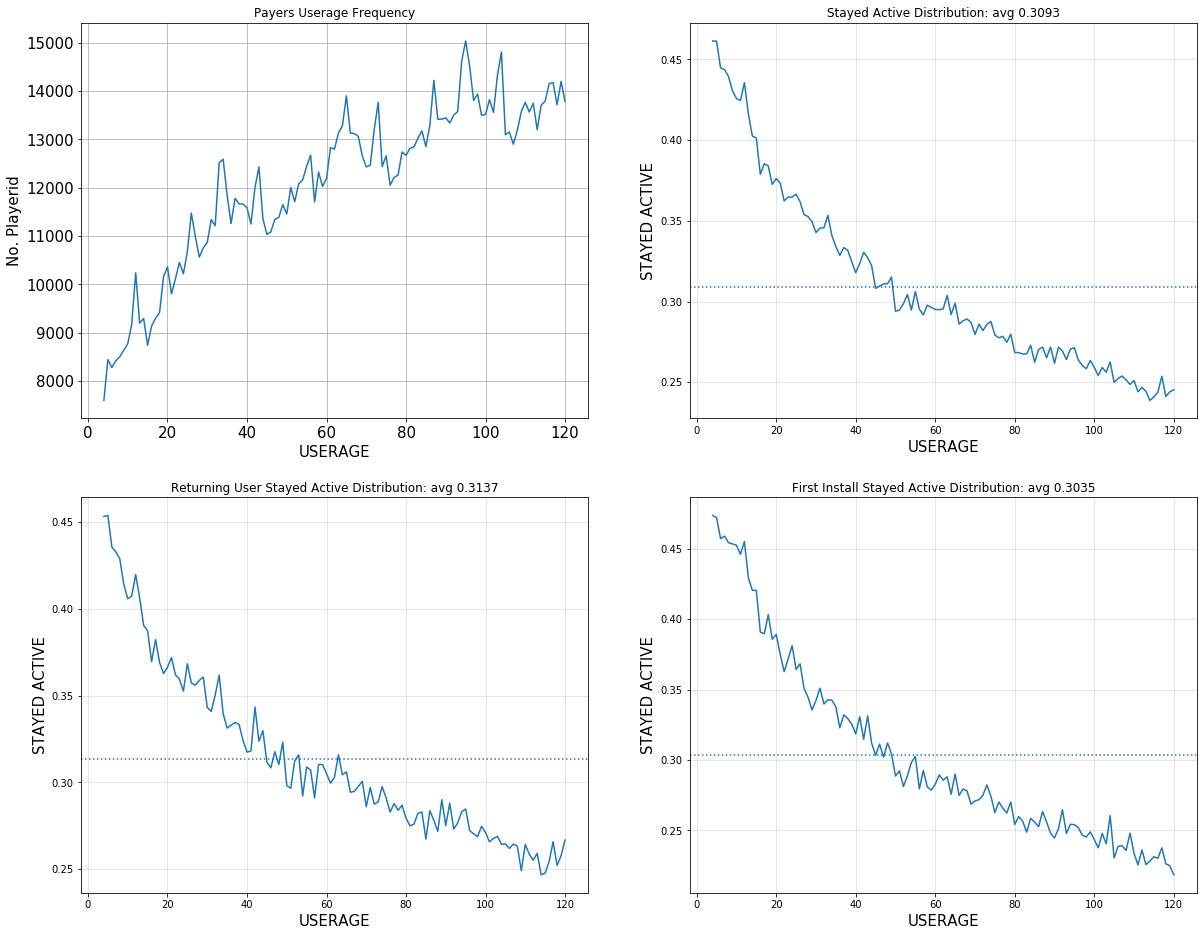

In [6]:
fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(nrows=2, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [1, 1],
                       height_ratios=[1, 1],
                       wspace=0.2,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,0:1])
ax2 = fig.add_subplot(gs[0,1:2])
ax3 = fig.add_subplot(gs[1,0:1])
ax4 = fig.add_subplot(gs[1,1:2])
# 1
ax11 = df_orig.USERAGE.value_counts().sort_index(ascending=True).plot(kind='line', title='Payers Userage Frequency', fontsize = 15, grid=True, ax=ax1)
ax11.set_xlabel("USERAGE", fontdict={'fontsize':15})
ax11.set_ylabel("No. Playerid", fontdict={'fontsize':15})
# 2
mean_df = df_orig[['USERAGE','STAYED_ACTIVE_6_MONTHS']].groupby('USERAGE').mean()
ax2.plot(mean_df)
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax2.axhline(y=mean_df.STAYED_ACTIVE_6_MONTHS.mean(), ls='dotted')
ax2.set_xlabel("USERAGE", fontdict={'fontsize':15})
ax2.set_ylabel("STAYED ACTIVE", fontdict={'fontsize':15})
ax2.set_title('Stayed Active Distribution: avg '+str(round(mean_df.STAYED_ACTIVE_6_MONTHS.mean(),4)))
# 3
df_RU1 = df_orig[df_orig.RETURNING_USER==1]
mean_df_RU1 = df_RU1[['USERAGE','STAYED_ACTIVE_6_MONTHS']].groupby('USERAGE').mean()
ax3.plot(mean_df_RU1)
ax3.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax3.axhline(y=mean_df_RU1.STAYED_ACTIVE_6_MONTHS.mean(), ls='dotted')
ax3.set_xlabel("USERAGE", fontdict={'fontsize':15})
ax3.set_ylabel("STAYED ACTIVE", fontdict={'fontsize':15})
ax3.set_title('Returning User Stayed Active Distribution: avg '+str(round(mean_df_RU1.STAYED_ACTIVE_6_MONTHS.mean(),4)))
df_RU0 = df_orig[df_orig.RETURNING_USER==0]
mean_df_RU0 = df_RU0[['USERAGE','STAYED_ACTIVE_6_MONTHS']].groupby('USERAGE').mean()
ax4.plot(mean_df_RU0)
ax4.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax4.axhline(y=mean_df_RU0.STAYED_ACTIVE_6_MONTHS.mean(), ls='dotted')
ax4.set_xlabel("USERAGE", fontdict={'fontsize':15})
ax4.set_ylabel("STAYED ACTIVE", fontdict={'fontsize':15})
ax4.set_title('First Install Stayed Active Distribution: avg '+str(round(mean_df_RU0.STAYED_ACTIVE_6_MONTHS.mean(),4)))
plt.show()

In [7]:
columns_rejected = [
    'FBADGROUPID','NETWORKNAME','CAMPAIGN_ID','CAMPAIGNNAME','ADGROUPNAME','CREATIVENAME','COUNTRYCODE',
    'ADJUSTDEVICEID','DEVICEADID','FIRST_INSTALL','LAST_INSTALL',
    'STAYED_ACTIVE_6_MONTHS','STAYED_ACTIVE_9_MONTHS','STAYED_ACTIVE_12_MONTHS','STAYED_ACTIVE_14_MONTHS',
    'STAYED_ACTIVE_16_MONTHS','STAYED_ACTIVE_18_MONTHS','STAYED_ACTIVE_21_MONTHS','STAYED_ACTIVE_24_MONTHS',
    'TOTAL_PURCHASES_NEXT3MONTHS','TOTAL_REVENUE_NEXT3MONTHS','TOTAL_PURCHASES_NEXT6MONTHS',
    'LAST_ACTIVE_DATE','DATE_MONTH','DATE_YEAR','MAXDATEPURCHASE','MINDATEPURCHASE','LAST_RUN',
    'TOTAL_REVENUE_NEXT6MONTHS','TOTAL_PURCHASES_NEXT9MONTHS','TOTAL_REVENUE_NEXT9MONTHS',
    'TOTAL_PURCHASES_NEXT12MONTHS','TOTAL_REVENUE_NEXT12MONTHS','TOTAL_PURCHASES_NEXT14MONTHS',
    'TOTAL_REVENUE_NEXT14MONTHS','TOTAL_PURCHASES_NEXT16MONTHS','TOTAL_REVENUE_NEXT16MONTHS',
    'TOTAL_PURCHASES_NEXT18MONTHS','TOTAL_REVENUE_NEXT18MONTHS','TOTAL_PURCHASES_NEXT21MONTHS',
    'TOTAL_REVENUE_NEXT21MONTHS','TOTAL_PURCHASES_NEXT24MONTHS','TOTAL_REVENUE_NEXT24MONTHS',
    'PERIOD','PSPLAYERID','INSTALL_SOURCE','SOURCE_TYPE','SOURCE_VERTICAL','MVM','NOT_PAID','PAID_INCENT',
    'PAID_NET','PAID_PROG','PAID_SANS','XPROMO','LVL_LAST_7_DAYS','LVL_LAST_3_MONTH',
    'TOTAL_LP_LAST_7_DAYS','TOTAL_LP_LAST_3_MONTH','NUM_DAYS_LOGIN_LAST_7_DAYS','NUM_DAYS_LOGIN_LAST_3_MONTH',
    'SUM_SESSIONS_LAST_7_DAYS', 'SUM_SESSIONS_LAST_3_MONTH','SUM_SPINS_LAST_7_DAYS','SUM_SPINS_LAST_3_MONTH',
    'SUM_COIN_IN_LAST_7_DAYS','SUM_COIN_IN_LAST_3_MONTH','FREQ_BET_LAST_7_DAYS','FREQ_BET_LAST_3_MONTH',
    'SUM_SUM_SESSION_LENGTH_SECS_LAST_7_DAYS','SUM_SUM_SESSION_LENGTH_SECS_LAST_3_MONTH', 
    'NUM_PURCHASES_LAST3_DAYS','TOT_REVENUE_LAST3_DAYS','NUM_PURCHASES_LAST7_DAYS','TOT_REVENUE_LAST7_DAYS',
    'NUM_PURCHASES_LAST14_DAYS','TOT_REVENUE_LAST14_DAYS','NUM_PURCHASES_LAST3MONTHS',
    'TOT_REVENUE_LAST3MONTHS','NUM_DAYS_SPINNER_LAST_7_DAYS','NUM_DAYS_SPINNER_LAST_3_MONTH','MEDIANPURCHASE',
    'NUM_PURCHASES_FIRST3_DAYS','TOT_REVENUE_FIRST3_DAYS','NUM_PURCHASES_FIRST30_DAYS','TOT_REVENUE_FIRST30_DAYS',
    'TOTAL_LP', 'TOTAL_LP_LAST_1_MONTH','SUM_SESSION_LENGTH_SECS','SUM_SUM_SESSION_LENGTH_SECS_LAST_1_MONTH']

#### Transform columns in Log1p

In [8]:
col2transform = ['LVL', 'SUM_SPINS', 'SUM_COIN_IN', 'FREQ_BET', 'DAILY_SPINS', 'DAILY_LVL', 'DAILY_SESSIONS']
for log_k in col2transform:
    df_orig['log_'+str(log_k)] = np.log1p(df_orig[log_k])

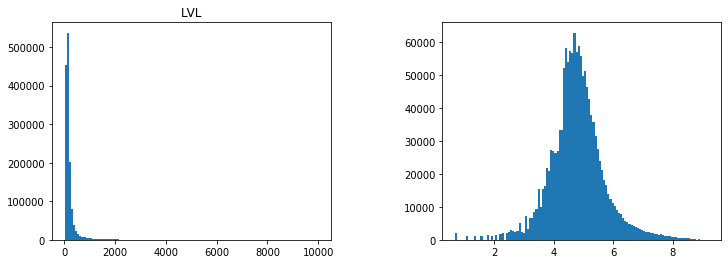

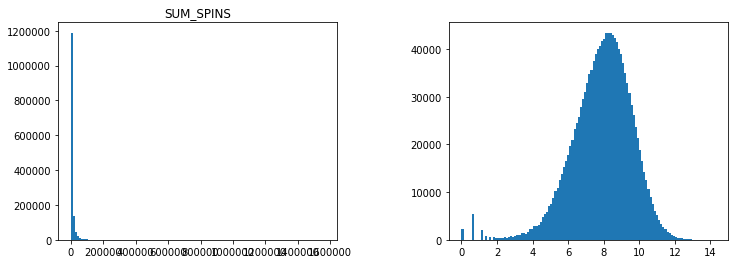

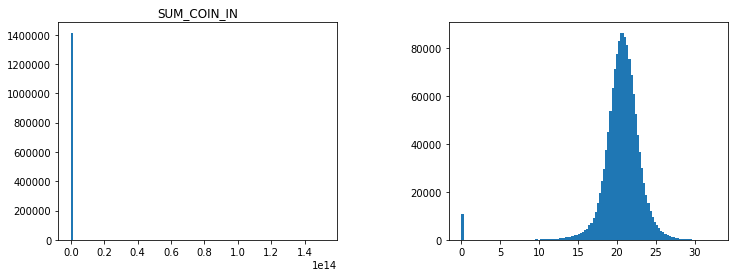

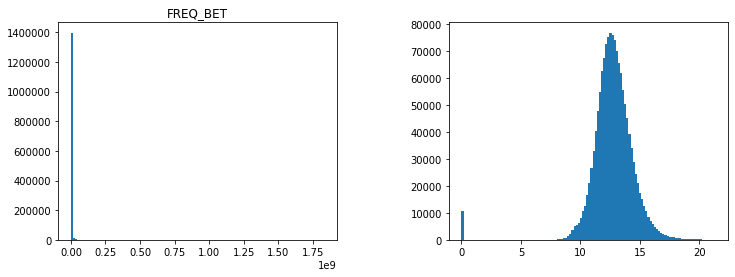

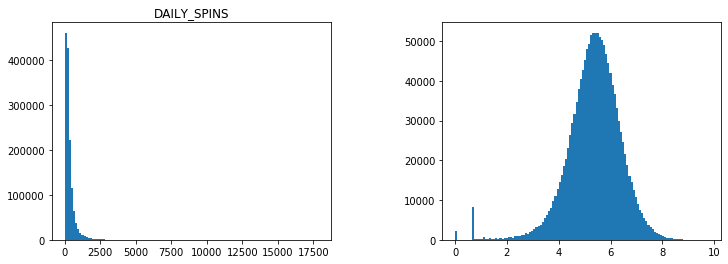

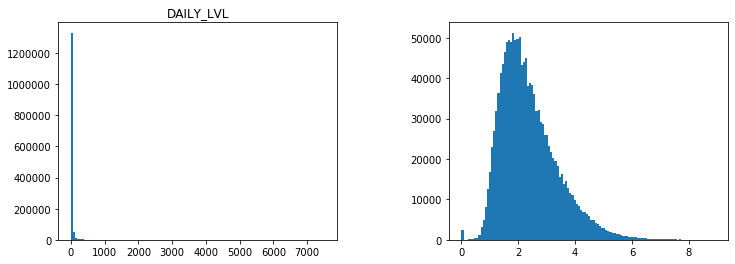

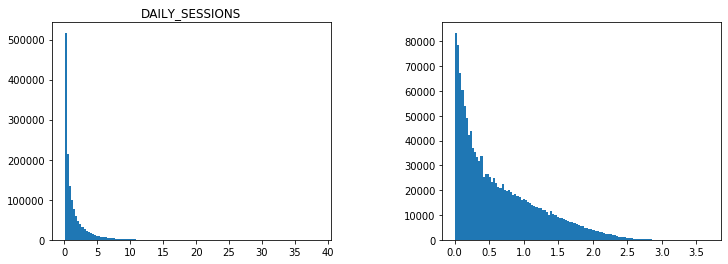

In [9]:
for j in col2transform:
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(nrows=1, 
                           ncols=2, 
                           figure=fig, 
                           width_ratios= [1, 1],
                           height_ratios=[1],
                           wspace=0.4,
                           hspace=0.2)
    ax1 = fig.add_subplot(gs[0,0:1])
    ax2 = fig.add_subplot(gs[0,1:2])
    ax1.hist(df_orig[j], bins=120)
    ax2.hist(np.log1p(df_orig[j]), bins=120)
    ax1.set_title(j)
    plt.show()

In [10]:
ls = list(set(columns_rejected + col2transform))
Y = df_orig
X = df_orig.drop(columns=ls)

In [11]:
X.head(5)

,FB_CONNECTED,COUNTRY_US,USERAGE,DAYS_SINCE_FIRST_INSTALL,IOS_PLATFORM,GPS_PLATFORM,ISORPHANED,RETURNING_USER,MAX_REV_TODAY,MAX_TRX_TODAY,SUM_REV_TODAY,SUM_TRX_TODAY,LVL_LAST_1_MONTH,NUM_DAYS_LOGIN,NUM_DAYS_LOGIN_LAST_1_MONTH,LAST_TIME_SEEN,AVGPURCHASE,DAYSMONETIZER,SUM_SESSIONS,SUM_SESSIONS_LAST_1_MONTH,SUM_SPINS_LAST_1_MONTH,SUM_COIN_IN_LAST_1_MONTH,FREQ_BET_LAST_1_MONTH,FTD_AGE,LAST_PURCHASE,NUM_PURCHASES_FIRST7_DAYS,TOT_REVENUE_FIRST7_DAYS,NUM_PURCHASES_LAST_MONTH,TOT_REVENUE_LAST_MONTH,NUM_DAYS_SPINNER,NUM_DAYS_SPINNER_LAST_1_MONTH,MX,ORGANIC,IOS_PLATFORM_RATIO,SPINNER_RATIO,log_LVL,log_SUM_SPINS,log_SUM_COIN_IN,log_FREQ_BET,log_DAILY_SPINS,log_DAILY_LVL,log_DAILY_SESSIONS
0,1,1,120,351,16,0,0,1,154.93,7.0,39.98,2.0,150,16,0,96,19.990000,2,23,0,0,0,0.000000,0,101,1,9.99,0,0.00,16,0,0,1,1.0,1.000000,5.017280,8.050384,22.007748,13.957683,5.282569,2.339399,0.175353
1,0,1,120,0,33,0,0,0,27.95,5.0,27.95,5.0,52,33,8,1,6.987500,4,41,9,851,190260000,223572.267920,31,13,0,0.00,2,18.97,33,8,0,1,1.0,1.000000,4.174387,8.202482,19.953099,11.750899,4.714704,1.078203,0.293913
2,1,1,120,0,0,32,0,0,99.92,8.0,99.92,8.0,116,32,0,78,16.653333,6,70,0,0,0,0.000000,1,86,1,4.99,0,0.00,32,0,0,0,0.0,1.000000,4.762174,9.176680,21.362215,12.185643,5.714145,1.531476,0.459532
3,1,1,120,1765,74,0,0,1,5.98,2.0,5.98,2.0,58,74,6,11,2.990000,2,131,6,17,5280000,310588.235294,5,101,1,3.99,0,0.00,68,4,0,1,1.0,0.918919,4.077537,6.418365,19.503227,13.086497,2.302585,0.616774,0.737961
4,1,1,120,0,0,10,0,0,47.95,5.0,47.95,5.0,99,10,0,86,11.987500,4,11,0,0,0,0.000000,2,86,1,9.99,0,0.00,10,0,0,1,0.0,1.000000,4.605170,7.268920,20.868197,13.599975,4.972587,2.388763,0.087706


## Classifications Stayed Active in 6 Months

#### Define Train and Test

In [12]:
# Splitting into Train, Validation and Test
if NNClassification:
    from keras import Sequential
    from keras.layers import Dense, Dropout
    import keras
    import tensorflow as tf
    from sklearn.preprocessing import StandardScaler
    feature_name = X.columns
    scaler = StandardScaler()
    scaler.fit(X)
    Scaled_X = scaler.transform(X) 
    X_train_ps, X_test_ps, y_train, y_test = train_test_split(Scaled_X, Y, test_size=0.20, stratify=Y['STAYED_ACTIVE_6_MONTHS'], random_state=1)
    print(X_train_ps.shape, X_test_ps.shape)
else:
    feature_name = X.columns
    X_train_ps, X_test_ps, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y['STAYED_ACTIVE_6_MONTHS'], random_state=1)
    X_train_ps, X_val_ps, y_train, y_val = train_test_split(X_train_ps, y_train, test_size=0.25, stratify=y_train['STAYED_ACTIVE_6_MONTHS'], random_state=1) 
    print(X_train_ps.shape, X_val_ps.shape, X_test_ps.shape)

Using TensorFlow backend.


(1133116, 42) (283280, 42)


In [13]:
def NN_GetModel():
    model = Sequential()
    model.add(Dense(units=24, kernel_initializer='uniform', activation='relu', input_dim = X_train_ps.shape[1]))
    model.add(Dropout (p = 0.1))
    model.add(Dense(units=12, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(units=4,  kernel_initializer='uniform', activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

#### Classification Algorithm

In [14]:
if Class_PreLoad:  # Already Trained
    if NNClassification:
        model = NN_GetModel()
        model.load_weights("./Model/Model_Adjust_EDW/NN"+str(Segment)+"_ClusterSegment_classification_"+str(MonthPrediction)+"Months_model_v4.h5")
    else:
        xg_train = xgb.DMatrix(X_train_ps, label=y_train['STAYED_ACTIVE_6_MONTHS'])
        xg_val = xgb.DMatrix(X_val_ps, label=y_val['STAYED_ACTIVE_6_MONTHS'])
        xg_test = xgb.DMatrix(X_test_ps, label=y_test['STAYED_ACTIVE_6_MONTHS'])
        model = xgb.Booster({'nthread': -1})  # init model
        model.load_model('./Model/Model_Adjust_EDW/EDW_3Factors_XGB_payers_classification_6Months_model.model')
else:
    if NNClassification:
        # NEURAL NETWORK
        model = NN_GetModel()
        earlystop = keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.0001, patience=10, verbose=0, mode='auto')
        model.fit(X_train_ps, y_train['STAYED_ACTIVE_6_MONTHS'], 
                     epochs=250, 
                     batch_size=1024,
                     callbacks=[earlystop], 
                     validation_split=0.25,
                     verbose=1, 
                     shuffle=True)
    else:
        # EXTREME GRADIENT BOOSTING
        xg_train = xgb.DMatrix(X_train_ps, label=y_train['STAYED_ACTIVE_6_MONTHS'])
        xg_val = xgb.DMatrix(X_val_ps, label=y_val['STAYED_ACTIVE_6_MONTHS'])
        xg_test = xgb.DMatrix(X_test_ps, label=y_test['STAYED_ACTIVE_6_MONTHS'])
        watchlist = [(xg_train, 'train'), (xg_val, 'validation')]
        params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'tree_method':'hist',
              'max_depth': 12,
              'eta': 0.01,
              'booster': 'gbtree',
              'sampling_method':'uniform',
              'gamma': 0,
              'min_child_weight': 6,
              'subsample': 0.8,
              'alpha': 0.01,
              'lambda': 0.01,
              'max_bin': 128}
        model = xgb.train(params, xg_train, 5000, watchlist, early_stopping_rounds = 10)

Train on 849837 samples, validate on 283279 samples
Epoch 1/250
849837/849837 [==============================] - 7s 8us/step - loss: 0.4915 - accuracy: 0.7645 - auc: 0.7611 - val_loss: 0.4771 - val_accuracy: 0.7718 - val_auc: 0.7910
Epoch 2/250
849837/849837 [==============================] - 6s 7us/step - loss: 0.4778 - accuracy: 0.7718 - auc: 0.7953 - val_loss: 0.4744 - val_accuracy: 0.7733 - val_auc: 0.7980
Epoch 3/250
849837/849837 [==============================] - 6s 7us/step - loss: 0.4756 - accuracy: 0.7730 - auc: 0.7995 - val_loss: 0.4721 - val_accuracy: 0.7744 - val_auc: 0.8009
Epoch 4/250
849837/849837 [==============================] - 6s 7us/step - loss: 0.4743 - accuracy: 0.7737 - auc: 0.8018 - val_loss: 0.4717 - val_accuracy: 0.7748 - val_auc: 0.8026
Epoch 5/250
849837/849837 [==============================] - 6s 7us/step - loss: 0.4738 - accuracy: 0.7739 - auc: 0.8032 - val_loss: 0.4711 - val_accuracy: 0.7753 - val_auc: 0.8037
Epoch 6/250
849837/849837 [================

In [15]:
# save model
if SaveModel:
    if NNClassification:
        model.save("./Model/Model_EDW/EDW_3Factors_NN"+str(Segment)+"_classification_"+str(MonthPrediction)+"Months_model_v4.h5")
    else:
        model.save_model("./Model/Model_EDW/EDW_3Factors_XGB_"+str(Segment)+"_classification_"+str(MonthPrediction)+"Months_model.model")
        model.dump_model("./Model/Model_EDW/EDW_3Factors_XGB_"+str(Segment)+"_classification_"+str(MonthPrediction)+"Months_model.raw.txt")

#### Performance

In [16]:
# Performance
if NNClassification: y_test['preds'] = model.predict(X_test_ps)
else: y_test['preds'] = model.predict(xg_test)
AUC, cut = BestPredCut(y_test,'STAYED_ACTIVE_6_MONTHS', metric='F1_Score') # Accuracy, Precision, Recall, F1_Score
print('Threshold Cut: '+str(round(cut, 4)))
y_test['preds_cut'] = 1* (y_test['preds']>=cut)
conf_mat = sklearn.metrics.confusion_matrix(y_test['STAYED_ACTIVE_6_MONTHS'],y_test[['preds_cut']])
tn, fp, fn, tp = conf_mat.ravel()
print('\nTrue Neg: '+str(tn)+' False Pos: '+str(fp)+'\nFalse Neg: '+str(fn)+' True Pos: '+str(tp)+'\n')
Accuracy, Precision, Recall = (tn+tp)/(tn+tp+fn+fp), tp/(tp+fp), tp/(fn+tp)
F1Score = 2*((Precision*Recall)/(Precision+Recall))
print('Accuracy: '+str(Accuracy)+'\nPrecision: '+str(Precision)+'\nRecall: '+str(Recall)+'\nF1-Score: '+str(F1Score))
print('\nROC AUC: ',str(AUC),'\n')
y_test['expected_rev'] = y_test['preds'] * y_test['TOTAL_REVENUE_NEXT6MONTHS']
y_test['expected_rev_cut'] = y_test['preds_cut'] * y_test['TOTAL_REVENUE_NEXT6MONTHS']
print('Revenue Coverage by Prediction Prb: '+str(round((np.sum(y_test['expected_rev']) / float(np.sum(y_test['TOTAL_REVENUE_NEXT6MONTHS'])))*100, 5))+'%')
print('Revenue Coverage by Prediction Cut: '+str(round((np.sum(y_test['expected_rev_cut']) / float(np.sum(y_test['TOTAL_REVENUE_NEXT6MONTHS'])))*100, 5))+'%')

Threshold Cut: 0.3

True Neg: 144389 False Pos: 53314
False Neg: 23016 True Pos: 62561

Accuracy: 0.7305492798644451
Precision: 0.5399007551240561
Recall: 0.7310492305175456
F1-Score: 0.6211008081329548

ROC AUC:  0.8120458241583437 

Revenue Coverage by Prediction Prb: 75.03401%
Revenue Coverage by Prediction Cut: 92.19464%


#### Feature Importance and ROC Curve

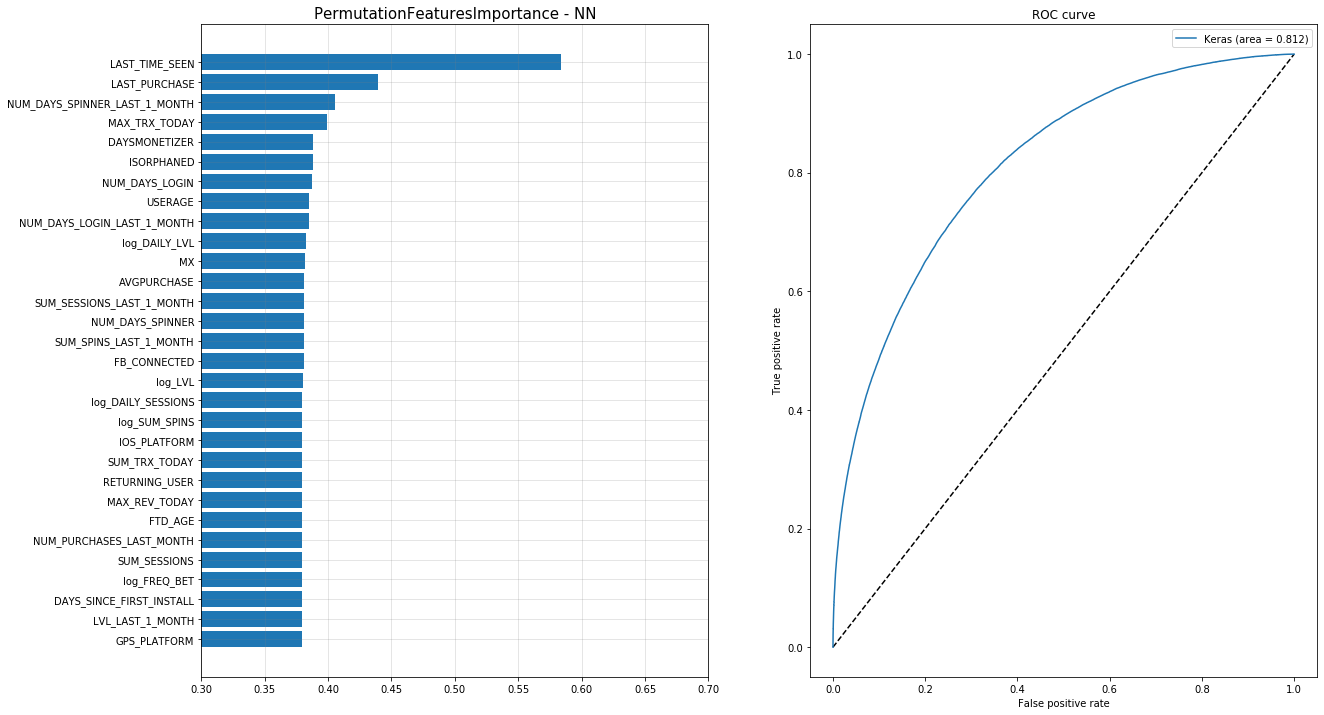

In [17]:
fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [1, 1],
                       height_ratios=[1],
                       wspace=0.2,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,0:1])
ax2 = fig.add_subplot(gs[0,1:2])
# 1
if NNClassification:
    plot, benchmark = PermutationFeaturesImportance(X_test_ps, feature_name, y_test['STAYED_ACTIVE_6_MONTHS'], model, cut, kpi='F1Score', max_num_features=30, ax=ax1)
    # 4
    ROC_Curve(model, X_test_ps, y_test['STAYED_ACTIVE_6_MONTHS'], ax=ax2)
    plt.show()
else:
    xgb.plot_importance(model, max_num_features=30, ax=ax1)
    ax1.set_ylabel("Loss")
    ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    # 4
    ROC_Curve(model, xg_test, y_test['STAYED_ACTIVE_6_MONTHS'], ax=ax2)
    plt.show()

#### Cross Entropy Decay

In [18]:
def CrossEntropy(x):
    cross_ent = - (x['STAYED_ACTIVE_6_MONTHS'] * np.log(x['preds']) + (1-x['STAYED_ACTIVE_6_MONTHS']) * np.log(1-x['preds']))
    return np.mean(cross_ent)

def ClassGroup(x, col):
    conf_mat = sklearn.metrics.confusion_matrix(x[['STAYED_ACTIVE_6_MONTHS']],x[['preds_cut']])
    tn, fp, fn, tp = conf_mat.ravel()
    exp_rev = np.sum(x['expected_rev_cut']) / float(np.sum(x[col]))        
    return [(tn+tp)/(tn+tp+fn+fp), tp/(tp+fp), tp/(fn+tp), 2*(((tp/(tp+fp))*(tp/(fn+tp)))/((tp/(tp+fp))+(tp/(fn+tp)))), exp_rev, len(x)]

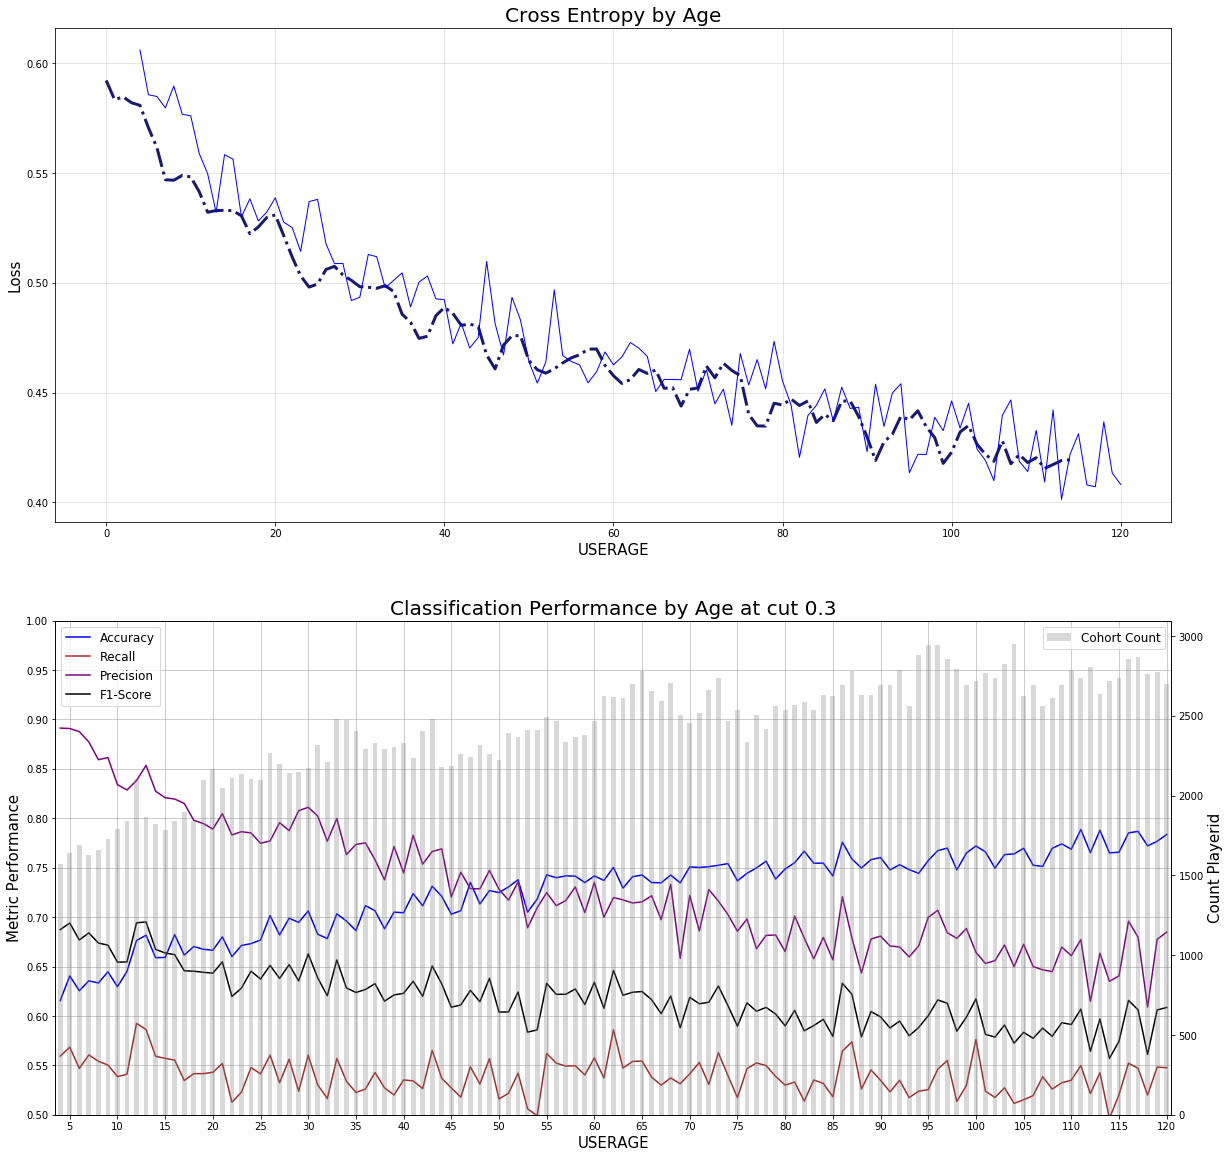

In [19]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(nrows=2, 
                       ncols=1, 
                       figure=fig, 
                       width_ratios= [1],
                       height_ratios=[1, 1],
                       wspace=0.2,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
# 1
ce = y_test.groupby('USERAGE').apply(CrossEntropy)
ax1.plot(MovingAverage([ce],3), 'midnightblue', ls='-.', lw=3)
ax1.plot(ce, 'blue', ls='-', lw=1)
ax1.set_xlabel("USERAGE",  fontdict={'fontsize':15})
ax1.set_ylabel("Loss",  fontdict={'fontsize':15})
ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax1.set_title('Cross Entropy by Age', fontsize = 20) 
# 2
perf_obj = y_test.groupby('USERAGE').apply(lambda x: ClassGroup(x,FeaturesPredict))
perf_df = pd.DataFrame(perf_obj.values.tolist(),index=perf_obj.index).reset_index(drop=True)
perf_df.rename(columns={0:"Accuracy",1:"Recall",2:"Precision",3:"F1_Score",4:"ExpRev",5:"Count"},inplace=True)
ax21 = ax2.twinx() # Create another axes that shares the same x-axis as ax.
ax2.plot(perf_df.Accuracy, 'blue')
ax2.plot(perf_df.Recall, 'brown')
ax2.plot(perf_df.Precision, 'purple')
ax2.plot(perf_df.F1_Score, 'black')
#ax2.plot(perf_df.ExpRev, '#90EE90')
ax2.set_ylim(0.5,1)
ax2.set_yticks(np.arange(0.5, 1.05, 0.05))
perf_df.Count.plot(kind='bar', color='gray', ax=ax21, alpha = 0.3)
ax2.set_xticks(np.arange(1, 121, 5))
ax2.set_xticklabels([x+5 for x in np.arange(0,120,5)])
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.4)
ax2.set_ylabel("Metric Performance",  fontdict={'fontsize':15})
ax21.set_ylabel("Count Playerid",  fontdict={'fontsize':15})
ax2.set_xlabel("USERAGE",  fontdict={'fontsize':15})
ax2.legend(['Accuracy','Recall','Precision','F1-Score'], loc ='upper left', fontsize = 'large') 
ax21.legend(['Cohort Count'], loc ='upper right', fontsize = 'large') 
ax2.set_title('Classification Performance by Age at cut '+str(round(cut,2)), fontsize = 20) 
plt.show()

## Prediction Revenue Next 6 Months

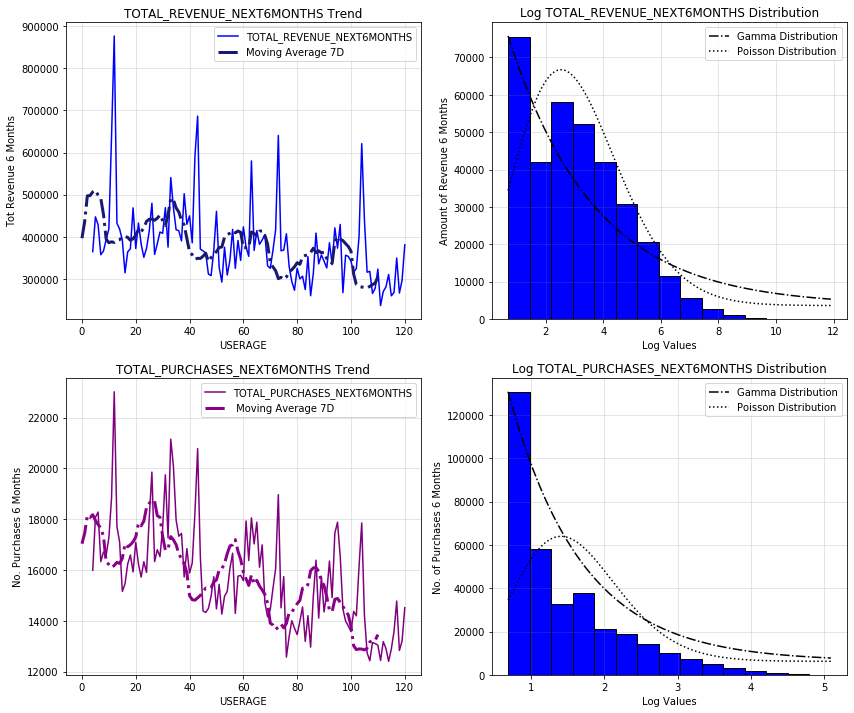

In [20]:
from scipy.stats import gamma, norm, poisson
y_train_group = y_train[['USERAGE',FutureRevenue,FuturePurchases]].groupby(['USERAGE']).sum()
y_train_dist = y_train[y_train[FutureRevenue]!=0]
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [1, 1],
                       height_ratios=[1, 1],
                       wspace=0.2,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,0:1])
ax2 = fig.add_subplot(gs[0,1:2])
ax3 = fig.add_subplot(gs[1,0:1])
ax4 = fig.add_subplot(gs[1,1:2])
ax1.plot(y_train_group[FutureRevenue], 'blue')
ax1.plot(MovingAverage([y_train_group[FutureRevenue]],7), 'midnightblue', ls='-.', lw=3)
ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax1.set_ylabel('Tot Revenue '+str(MonthPrediction)+' Months', fontdict={'fontsize':10})
ax1.set_xlabel('USERAGE', fontdict={'fontsize':10})
ax1.legend([FutureRevenue,'Moving Average 7D'], loc ='upper right', fontsize = 'medium')
ax1.set_title(str(FutureRevenue)+' Trend')
ax22 = ax2.twinx()
ax2.hist(np.log1p(y_train_dist[FutureRevenue]), bins = 15, color = 'blue', edgecolor = 'black')
distgamma1 = gamma(1, 0, 3)
mu = np.log1p(y_train_dist[FutureRevenue]).mean()
x = np.linspace(np.log1p(y_train_dist[FutureRevenue]).min(), np.log1p(y_train_dist[FutureRevenue]).max(), 1000)
distpoisson = np.exp(-mu)*np.power(mu, x)/factorial(x)
ax22.plot(x, distgamma1.pdf(x), ls='-.', c='black')
ax22.plot(x, distpoisson, ls=':', c='black')
ax22.set_axis_off() 
ax2.set_ylabel('Amount of Revenue '+str(MonthPrediction)+' Months', fontdict={'fontsize':10})
ax2.set_xlabel('Log Values', fontdict={'fontsize':10})
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax22.legend(['Gamma Distribution','Poisson Distribution'], loc ='upper right', fontsize = 'medium')
ax2.set_title('Log TOTAL_REVENUE_NEXT'+str(MonthPrediction)+'MONTHS'+' Distribution')
ax3.plot(y_train_group[FuturePurchases], 'purple')
ax3.plot(MovingAverage([y_train_group[FuturePurchases]],7), 'darkmagenta', ls='-.', lw=3)
ax3.set_ylabel('No. Purchases '+str(MonthPrediction)+' Months', fontdict={'fontsize':10})
ax3.set_xlabel('USERAGE', fontdict={'fontsize':10})
ax3.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax3.legend([str(FuturePurchases),' Moving Average 7D'], loc ='upper right', fontsize = 'medium')
ax3.set_title(str(FuturePurchases)+' Trend')
ax44 = ax4.twinx()
ax4.hist(np.log1p(y_train_dist[FuturePurchases]), bins = 15, color = 'blue', edgecolor = 'black')
distgamma2 = gamma(1, 0, 1)
mu = np.log1p(y_train_dist[FuturePurchases]).mean()
x = np.linspace(np.log1p(y_train_dist[FuturePurchases]).min(), np.log1p(y_train_dist[FuturePurchases]).max(), 1000)
ax44.plot(x, distgamma2.pdf(x), ls='-.', c='black')
ax44.plot(x, distpoisson, ls=':', c='black')
ax44.set_axis_off()
ax4.set_ylabel('No. of Purchases '+str(MonthPrediction)+' Months', fontdict={'fontsize':10})
ax4.set_xlabel('Log Values', fontdict={'fontsize':10})
ax4.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax44.legend(['Gamma Distribution','Poisson Distribution'], loc ='upper right', fontsize = 'medium')
ax4.set_title('Log TOTAL_PURCHASES_NEXT'+str(MonthPrediction)+'MONTHS'+' Distribution')
plt.show()

#### Pre-Processing Part2

In [21]:
avgp_index = feature_name.tolist().index('AVGPURCHASE') 

In [22]:
# Regression Method
RegMethod = 'Custom'    # Custom, RMSLE or Tweedie Regression
withCut   = False
Target    = FuturePurchases # FuturePurchases 'Purchases' (with weights) or FutureRevenue: 'Revenue'

In [23]:
if NNClassification:
    X_train_ps, X_val_ps, y_train, y_val = train_test_split(X_train_ps, y_train, test_size=0.25, random_state=1)
    xg_train_reg = xgboost_reg.DMatrix(pd.DataFrame(data=scaler.inverse_transform(X_train_ps), columns=feature_name), label=y_train[Target])
    xg_val_reg = xgboost_reg.DMatrix(pd.DataFrame(data=X_val_ps, columns=feature_name), label=y_val[Target])
    xg_test_reg = xgboost_reg.DMatrix(pd.DataFrame(data=scaler.inverse_transform(X_test_ps), columns=feature_name), label=y_test[Target])
else:
    xg_train_reg = xgb.DMatrix(X_train_ps, label=y_train[Target])
    xg_val_reg = xgb.DMatrix(X_val_ps, label=y_val[Target])
    xg_test_reg = xgb.DMatrix(X_test_ps, label=y_test[Target])
print(X_train_ps.shape, X_val_ps.shape, X_test_ps.shape)

(849837, 42) (283279, 42) (283280, 42)


#### Custom Asymmetric Loss Function

In [37]:
def custom_asymmetric_train(y_pred: np.ndarray, dtrain: xgb.DMatrix):
    y_true = dtrain.get_label()
    residual = (y_true - y_pred)
    grad = np.where(residual>0, 5.0*-2.0*residual, -2.0*residual)
    hess = np.where(residual>0, 5.0*2.0, 2.0)
    #list_res.append(np.mean(residual))
    #list_pred.append(y_pred)
    return grad, hess

def custom_asymmetric_eval(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    residual = (y - predt)
    w_res = np.where(residual>0, 5.0*2.0*residual, 2.0*residual)
    elements = np.power(w_res, 2.0)
    #list_ele.append(np.mean(elements))
    return 'eval_err',np.sqrt(float(np.sum(elements) / len(y)))

def rmsle(y_pred: np.ndarray, dtrain: xgb.DMatrix):
    labels = dtrain.get_label()
    diffs = np.log(y_pred + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

def Prediction(df_class, df_reg, avg_purchase, withCut, Target):
    ClassPred = model.predict(df_class)
    RegPred   = xgb_model_reg.predict(df_reg)
    if withCut: Prediction = RegPred.reshape(-1,1)*(1*(ClassPred.reshape(-1,1)>=cut))
    else: Prediction = RegPred.reshape(-1,1)*ClassPred.reshape(-1,1)
    if Target==FuturePurchases: Prediction = Prediction*np.array(avg_purchase).reshape(-1,1)
    return ClassPred, RegPred, Prediction

#### Regression Algorithm

In [38]:
if Reg_PreLoad:  # Already Trained     
    xgb_model_reg = xgb.Booster({'nthread': -1})  # init model
    xgb_model_reg.load_model('./Model/Model_EDW/EDW_3Factors_XGB_payers_regression_6Months_model.model')
else:
    # Predict Target
    watchlist = [(xg_train_reg, 'train'), (xg_val_reg, 'validation')]
    if RegMethod == 'Custom':
        params = {'disable_default_eval_metric':1,
                  'tree_method':'hist',
                  'max_depth': 8,
                  'eta': 0.01, 
                  'booster': 'gbtree',
                  'sampling_method':'uniform',
                  'gamma': 0,
                  'min_child_weight': 10,
                  'subsample': 0.8,
                  'alpha': 0.01,
                  'lambda': 1e-5,
                  'max_bin': 256}
        xgb_model_reg = xgboost_reg.train(params
                                          , xg_train_reg
                                          , 4000
                                          , evals = watchlist
                                          , early_stopping_rounds = 10
                                          , obj=custom_asymmetric_train
                                          , feval=custom_asymmetric_eval
                                          )
    elif RegMethod == 'RMSLE':
        params = {'disable_default_eval_metric':1,
                  'objective': 'reg:squarederror',
                  'tree_method':'hist',
                  'max_depth': 8,
                  'eta': 0.01, 
                  'booster': 'gbtree',
                  'sampling_method':'uniform',
                  'gamma': 0,
                  'min_child_weight': 10,
                  'subsample': 0.8,
                  'alpha': 0.01,
                  'lambda': 1e-5,
                  'max_bin': 128}
        xgb_model_reg = xgboost_reg.train(params
                                          , xg_train_reg
                                          , 4000
                                          , evals = watchlist
                                          , early_stopping_rounds = 10
                                          , feval= rmsle) 
    elif RegMethod == 'Tweedie':
        params = {'eval_metric' : 'tweedie-nloglik@1.4',
                  'objective': 'reg:tweedie',
                  'tree_method':'hist',
                  'max_depth': 8,
                  'eta': 0.01,
                  'booster': 'gbtree',
                  'sampling_method':'uniform',
                  'gamma': 0,
                  'min_child_weight': 10,
                  'subsample': 0.8,
                  'alpha': 0.1,
                  'lambda': 1e-5,
                  'max_bin': 128}
        xgb_model_reg = xgboost_reg.train(params
                                          , xg_train_reg
                                          , 4000
                                          , evals = watchlist
                                          , early_stopping_rounds = 10)

[0]	train-eval_err:58.25253	validation-eval_err:58.09174
Multiple eval metrics have been passed: 'validation-eval_err' will be used for early stopping.

Will train until validation-eval_err hasn't improved in 10 rounds.
[1]	train-eval_err:57.99315	validation-eval_err:57.93042
[2]	train-eval_err:57.73615	validation-eval_err:57.82578
[3]	train-eval_err:57.48168	validation-eval_err:57.76564
[4]	train-eval_err:57.23128	validation-eval_err:57.67131
[5]	train-eval_err:56.97904	validation-eval_err:57.55954
[6]	train-eval_err:56.72908	validation-eval_err:57.47816
[7]	train-eval_err:56.48330	validation-eval_err:57.38519
[8]	train-eval_err:56.23989	validation-eval_err:57.30383
[9]	train-eval_err:55.99562	validation-eval_err:57.19934
[10]	train-eval_err:55.75453	validation-eval_err:57.12842
[11]	train-eval_err:55.51445	validation-eval_err:57.04830
[12]	train-eval_err:55.27383	validation-eval_err:56.89720
[13]	train-eval_err:55.03564	validation-eval_err:56.82863
[14]	train-eval_err:54.79971	valida

[138]	train-eval_err:37.14974	validation-eval_err:47.79996
[139]	train-eval_err:37.07344	validation-eval_err:47.71751
[140]	train-eval_err:36.99993	validation-eval_err:47.60304
[141]	train-eval_err:36.92754	validation-eval_err:47.57937
[142]	train-eval_err:36.85633	validation-eval_err:47.52072
[143]	train-eval_err:36.78446	validation-eval_err:47.45808
[144]	train-eval_err:36.71415	validation-eval_err:47.40777
[145]	train-eval_err:36.64495	validation-eval_err:47.37673
[146]	train-eval_err:36.57618	validation-eval_err:47.33115
[147]	train-eval_err:36.50872	validation-eval_err:47.23074
[148]	train-eval_err:36.44191	validation-eval_err:47.18089
[149]	train-eval_err:36.37468	validation-eval_err:47.14254
[150]	train-eval_err:36.30828	validation-eval_err:47.10364
[151]	train-eval_err:36.24298	validation-eval_err:47.05789
[152]	train-eval_err:36.17719	validation-eval_err:47.04476
[153]	train-eval_err:36.11197	validation-eval_err:47.03159
[154]	train-eval_err:36.04788	validation-eval_err:47.007

[277]	train-eval_err:31.33973	validation-eval_err:43.88426
[278]	train-eval_err:31.31726	validation-eval_err:43.80633
[279]	train-eval_err:31.29554	validation-eval_err:43.78264
[280]	train-eval_err:31.27272	validation-eval_err:43.77654
[281]	train-eval_err:31.25132	validation-eval_err:43.73911
[282]	train-eval_err:31.23057	validation-eval_err:43.73741
[283]	train-eval_err:31.20859	validation-eval_err:43.72993
[284]	train-eval_err:31.18921	validation-eval_err:43.72513
[285]	train-eval_err:31.16914	validation-eval_err:43.70790
[286]	train-eval_err:31.14713	validation-eval_err:43.71580
[287]	train-eval_err:31.12583	validation-eval_err:43.70123
[288]	train-eval_err:31.10456	validation-eval_err:43.64947
[289]	train-eval_err:31.08292	validation-eval_err:43.64013
[290]	train-eval_err:31.06106	validation-eval_err:43.59557
[291]	train-eval_err:31.04260	validation-eval_err:43.57153
[292]	train-eval_err:31.02331	validation-eval_err:43.56611
[293]	train-eval_err:31.00297	validation-eval_err:43.551

In [26]:
if SaveModel:
    xgb_model_reg.save_model("./Model/Model_EDW/EDW_3Factors_XGB_"+str(Segment)+"_regression_"+str(MonthPrediction)+"Months_model.model")
    xgb_model_reg.dump_model("./Model/Model_EDW/EDW_3Factors_XGB_"+str(Segment)+"_regression_"+str(MonthPrediction)+"Months_model.raw.txt")

In [39]:
# Predict Test Set
if NNClassification:
    y_test['ClassPred'],y_test['RegPred'],y_test['Prediction']  = Prediction(X_test_ps, xg_test_reg, y_test.AVGPURCHASE, withCut, Target)
else:
    y_test['ClassPred'],y_test['RegPred'],y_test['Prediction']  = Prediction(xg_test, xg_test_reg, y_test.AVGPURCHASE, withCut, Target)

#### Performance

In [40]:
if Target == FuturePurchases:
    original_sum = np.sum(df_orig[Target])
    test_sum = np.sum(y_test[Target])
    sum1 = np.sum(xgb_model_reg.predict(xg_train_reg))
    sum2 = np.sum(xgb_model_reg.predict(xg_val_reg))
    sum3 = np.sum(xgb_model_reg.predict(xg_test_reg))
    predictive_sum = sum1+sum2+sum3
    print('Full Purchases in '+str(MonthPrediction)+' Months: '+str(f'{round(original_sum):,.0f}'))
    print('Full Purchases Predicted in '+str(MonthPrediction)+' Months: '+str(f'{round(predictive_sum):,.0f}'))
    print('Error on Full Dataset: '+str(round(((predictive_sum-original_sum)/original_sum)*100, 4))+'%')
    print('Test Purchases in '+str(MonthPrediction)+' Months: '+str(f'{round(test_sum):,.0f}'))
    print('Test Predicted Purchases in '+str(MonthPrediction)+' Months: '+str(f'{round(sum3):,.0f}'))
    print('Error on Test Dataset: '+str(round(((sum3-test_sum)/test_sum)*100, 4))+'%')

    original_sum = np.sum(df_orig[FutureRevenue])
    test_sum = np.sum(y_test[FutureRevenue])
    if NNClassification:
        train_class, train_reg, train_pred = Prediction(X_train_ps, xg_train_reg, pd.DataFrame(scaler.inverse_transform(X_train_ps)).iloc[:,avgp_index], withCut, Target)
        val_class, val_reg, val_pred = Prediction(X_val_ps, xg_val_reg, pd.DataFrame(scaler.inverse_transform(X_val_ps)).iloc[:,avgp_index], withCut, Target)
        test_class, test_reg, test_pred = Prediction(X_test_ps, xg_test_reg, pd.DataFrame(scaler.inverse_transform(X_test_ps)).iloc[:,avgp_index], withCut, Target)
    else:
        train_class, train_reg, train_pred = Prediction(xg_train, xg_train_reg, X_train_ps.AVGPURCHASE, withCut, Target)
        val_class, val_reg, val_pred = Prediction(xg_val, xg_val_reg, X_val_ps.AVGPURCHASE, withCut, Target)
        test_class, test_reg, test_pred = Prediction(xg_test, xg_test_reg, X_test_ps.AVGPURCHASE, withCut, Target)

    predictive_sum = train_pred.sum()+val_pred.sum()+test_pred.sum()
    print('\n3 Components Revenue Performance')
    print('Full Revenue in '+str(MonthPrediction)+' Months: $'+str(f'{round(original_sum, 2):,.2f}'))
    print('Full Revenue Predicted in '+str(MonthPrediction)+' Months: $'+str(f'{round(predictive_sum, 2):,.2f}'))
    print('Error on Full Dataset: '+str(round(((predictive_sum-original_sum)/original_sum)*100, 4))+'%')
    print('Test Revenue in '+str(MonthPrediction)+' Months: $'+str(f'{round(test_sum, 2):,.2f}'))
    print('Test Predict in '+str(MonthPrediction)+' Months: $'+str(f'{round(test_pred.sum(), 2):,.2f}'))
    print('Error on Test Dataset: '+str(round(((test_pred.sum()-test_sum)/test_sum)*100, 4))+'%')
else:
    original_sum = np.sum(df_orig[FutureRevenue])
    test_sum = np.sum(y_test[FutureRevenue])
    if NNClassification:
        train_class, train_reg, train_pred = Prediction(X_train_ps, xg_train_reg, pd.DataFrame(scaler.inverse_transform(X_train_ps)).iloc[:,avgp_index], withCut, Target)
        val_class, val_reg, val_pred = Prediction(X_val_ps, xg_val_reg, pd.DataFrame(scaler.inverse_transform(X_val_ps)).iloc[:,avgp_index], withCut, Target)
        test_class, test_reg, test_pred = Prediction(X_test_ps, xg_test_reg, pd.DataFrame(scaler.inverse_transform(X_test_ps)).iloc[:,avgp_index], withCut, Target)
    else:
        train_class, train_reg, train_pred = Prediction(xg_train, xg_train_reg, X_train_ps.AVGPURCHASE, withCut, Target)
        val_class, val_reg, val_pred = Prediction(xg_val, xg_val_reg, X_val_ps.AVGPURCHASE, withCut, Target)
        test_class, test_reg, test_pred = Prediction(xg_test, xg_test_reg, X_test_ps.AVGPURCHASE, withCut, Target)

    predictive_sum = train_pred.sum()+val_pred.sum()+test_pred.sum()
    print('\n3 Components Revenue Performance')
    print('Full Revenue in '+str(MonthPrediction)+' Months: $'+str(f'{round(original_sum, 2):,.2f}'))
    print('Full Revenue Predicted in '+str(MonthPrediction)+' Months: $'+str(f'{round(predictive_sum, 2):,.2f}'))
    print('Error on Full Dataset: '+str(round(((predictive_sum-original_sum)/original_sum)*100, 4))+'%')
    print('Test Revenue in '+str(MonthPrediction)+' Months: $'+str(f'{round(test_sum, 2):,.2f}'))
    print('Test Predict in '+str(MonthPrediction)+' Months: $'+str(f'{round(test_pred.sum(), 2):,.2f}'))
    print('Error on Test Dataset: '+str(round(((test_pred.sum()-test_sum)/test_sum)*100, 4))+'%')

Full Purchases in 6 Months: 2,303,281
Full Purchases Predicted in 6 Months: 4,723,878
Error on Full Dataset: 105.0935%
Test Purchases in 6 Months: 463,993
Test Predicted Purchases in 6 Months: 973,730
Error on Test Dataset: 109.8588%

3 Components Revenue Performance
Full Revenue in 6 Months: $56,178,683.06
Full Revenue Predicted in 6 Months: $53,351,089.46
Error on Full Dataset: -5.0332%
Test Revenue in 6 Months: $11,419,971.92
Test Predict in 6 Months: $11,579,702.24
Error on Test Dataset: 1.3987%


#### Graphs - Global Performance

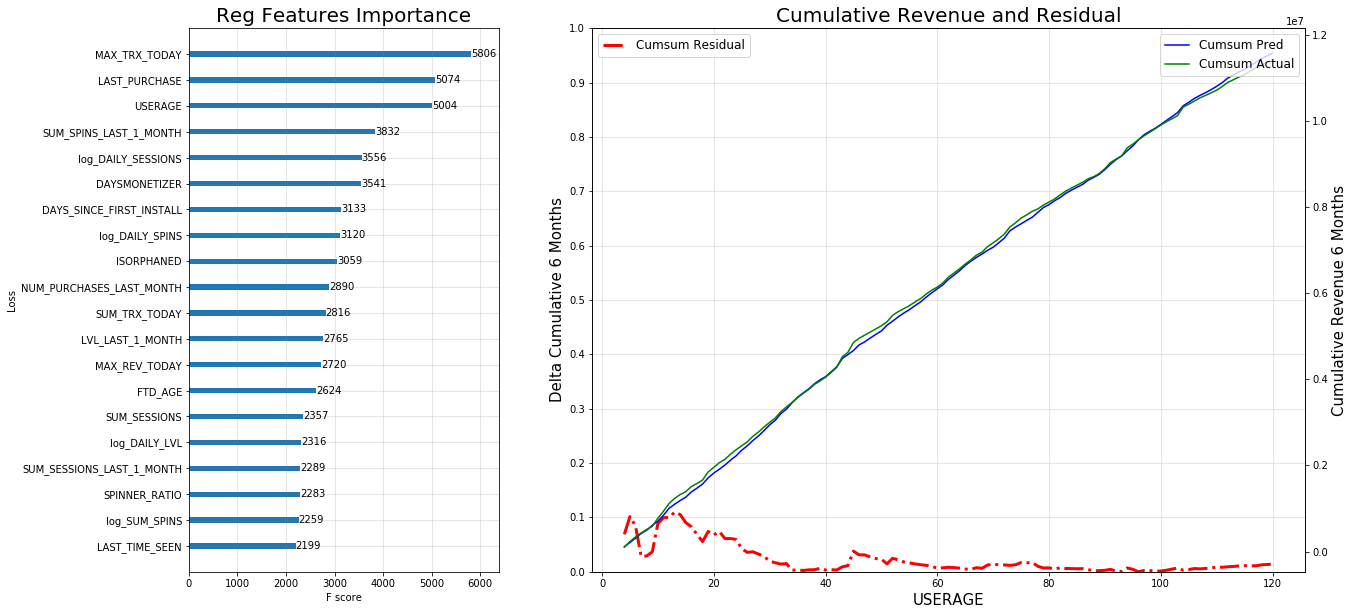

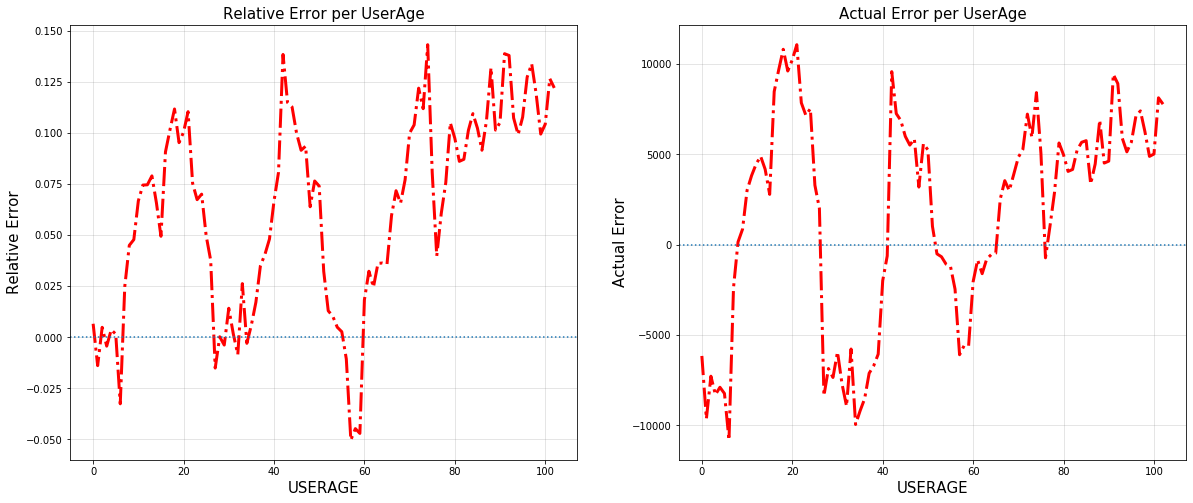

In [42]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(nrows=1, 
                       ncols=3, 
                       figure=fig, 
                       width_ratios= [1, 1, 1],
                       height_ratios=[1],
                       wspace=0.3,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,0:1])
ax2 = fig.add_subplot(gs[0,1:3])
xgboost_reg.plot_importance(xgb_model_reg, max_num_features=20, ax=ax1)
ax1.set_ylabel("Loss")
ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax1.set_title('Reg Features Importance', fontsize = 20)
cumtest = y_test
cumtest = cumtest.sort_values(['USERAGE'])
cumtest = cumtest[['USERAGE','Prediction',FutureRevenue]].groupby('USERAGE').sum()
cumtest['CUMSUM_PRED'] = cumtest[['Prediction']].cumsum()
cumtest['CUMSUM_REV'] = cumtest[[FutureRevenue]].cumsum()
cumtest['CUMSUM_RES'] = (cumtest['CUMSUM_REV']-cumtest['CUMSUM_PRED']).abs()
ax22 = ax2.twinx()
ax22.plot(cumtest.CUMSUM_PRED, 'blue')
ax22.plot(cumtest.CUMSUM_REV, 'green')
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax2.plot(cumtest.CUMSUM_RES/cumtest.CUMSUM_REV, 'red', ls='-.', lw=3)
ax2.set_yticks(np.arange(0,1.1,.1))
ax2.set_ylim(0,1)
ax22.legend(['Cumsum Pred','Cumsum Actual'], loc ='upper right', fontsize = 'large')
ax22.set_ylabel('Cumulative Revenue '+str(MonthPrediction)+' Months', fontdict={'fontsize':15})
ax2.set_ylabel('Delta Cumulative '+str(MonthPrediction)+' Months', fontdict={'fontsize':15})
ax2.set_xlabel('USERAGE', fontdict={'fontsize':15})
ax2.legend(['Cumsum Residual'], loc ='upper left', fontsize = 'large')
plt.title('Cumulative Revenue and Residual', size=20)
plt.show()
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [1, 1],
                       height_ratios=[1],
                       wspace=0.2,
                       hspace=0.2)
ax3 = fig.add_subplot(gs[0,0:1])
ax4 = fig.add_subplot(gs[0,1:2])
ax3.plot(MovingAverage([(cumtest.Prediction-cumtest[FutureRevenue])/cumtest[FutureRevenue]],15), 'red', ls='-.', lw=3)
ax3.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax3.axhline(y=0, ls='dotted')
ax3.set_ylabel('Relative Error', fontdict={'fontsize':15})
ax3.set_xlabel('USERAGE', fontdict={'fontsize':15})
ax3.set_title('Relative Error per UserAge', size = 15)
ax4.plot(MovingAverage([cumtest.Prediction-cumtest[FutureRevenue]],15), 'red', ls='-.', lw=3)
ax4.axhline(y=0, ls='dotted')
ax4.set_ylabel('Actual Error', fontdict={'fontsize':15})
ax4.set_xlabel('USERAGE', fontdict={'fontsize':15})
ax4.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax4.set_title('Actual Error per UserAge', size = 15)
plt.show()

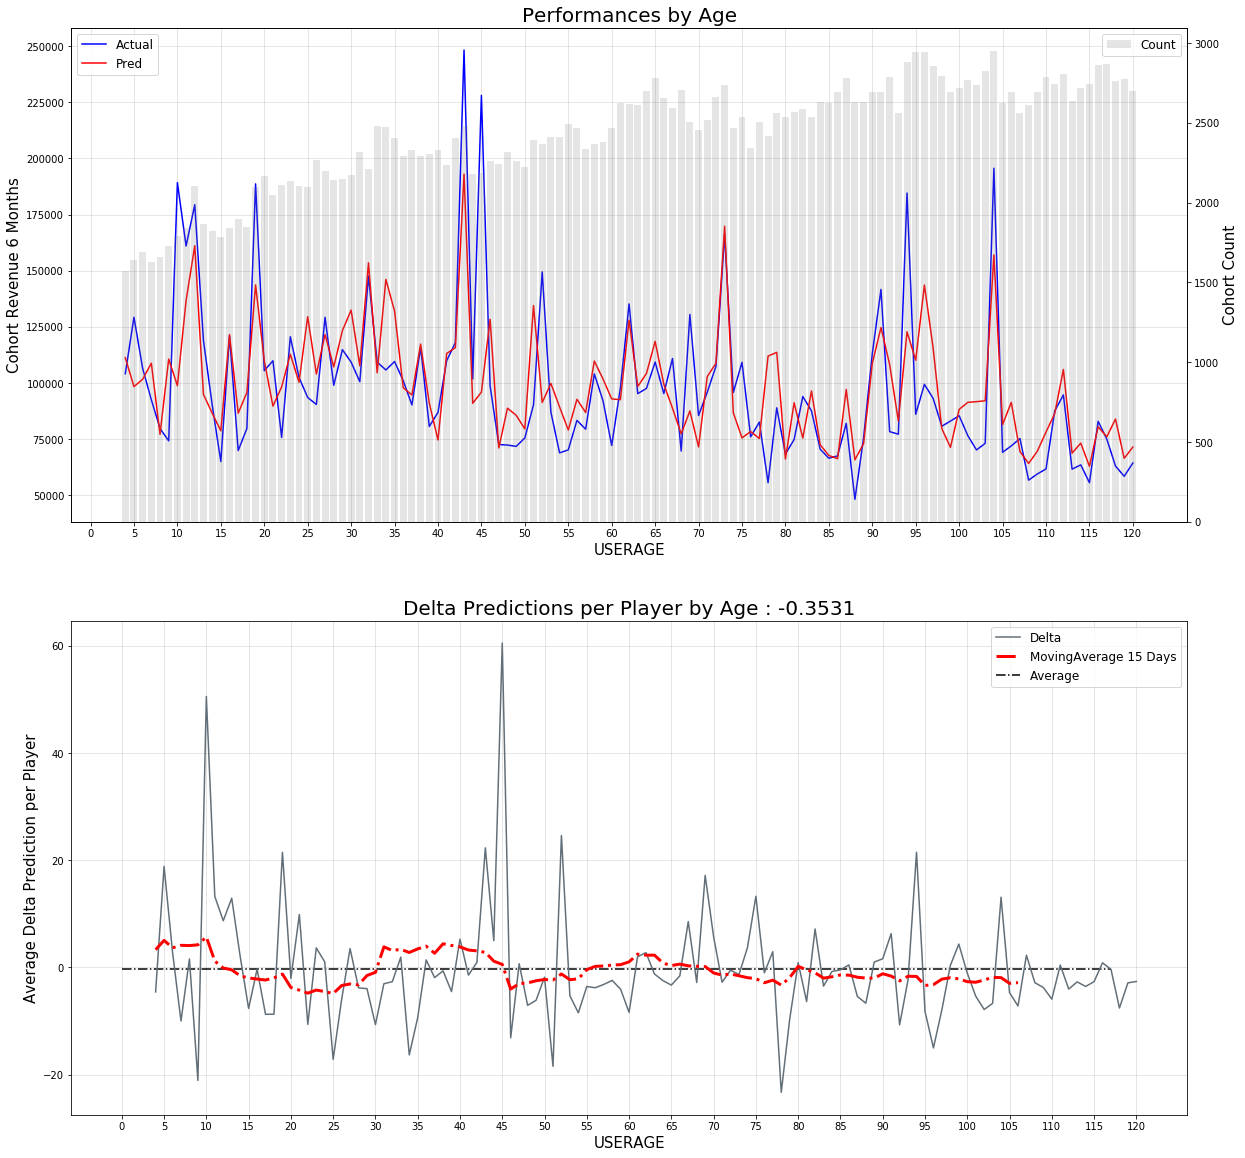

In [43]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(nrows=2, 
                       ncols=1, 
                       figure=fig, 
                       width_ratios= [1],
                       height_ratios=[1, 1],
                       wspace=0.2,
                       hspace=0.2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
reg_perf_obj = y_test.groupby('USERAGE').apply(lambda x: RegGroup(x,FutureRevenue))
reg_perf_df = pd.DataFrame(reg_perf_obj.values.tolist(),index=reg_perf_obj.index)
reg_perf_df.rename(columns={0: "Rev", 1: "Pred", 2: "Error_std", 3: "Count"}, inplace=True)
ax11 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax1.plot(reg_perf_df.Rev, 'blue')
ax1.plot(reg_perf_df.Pred, 'red')
ax11.bar(reg_perf_df.index, reg_perf_df.Count, color='gray', alpha = 0.2)
ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax1.legend(['Actual','Pred'], loc ='upper left', fontsize = 'large') 
ax1.set_ylabel('Cohort Revenue '+str(MonthPrediction)+' Months', fontdict={'fontsize':15})
ax11.set_ylabel('Cohort Count', fontdict={'fontsize':15})
ax1.set_xlabel('USERAGE', fontdict={'fontsize':15})
ax1.set_xticks(np.arange(0, 121, 5))
ax1.set_xticklabels([x for x in np.arange(0,121,5)])
ax11.legend(['Count'], loc ='upper right', fontsize = 'large') 
ax1.set_title('Performances by Age', fontsize = 20)
# 4
ax2.plot(reg_perf_df.Rev/reg_perf_df.Count-reg_perf_df.Pred/reg_perf_df.Count, '#626F78')
ax2.plot(np.arange(4,107,1),MovingAverage([reg_perf_df.Rev/reg_perf_df.Count-reg_perf_df.Pred/reg_perf_df.Count], 15),'red', ls='-.', lw=3)
ax2.hlines(np.mean(reg_perf_df.Rev/reg_perf_df.Count-reg_perf_df.Pred/reg_perf_df.Count), 0, len(reg_perf_df), linestyles='-.')
ax2.set_xticks(np.arange(0, 121, 5))
ax2.set_xticklabels([x for x in np.arange(0,121,5)])
ax2.set_ylabel('Average Delta Prediction per Player', fontdict={'fontsize':15})
ax2.set_xlabel('USERAGE', fontdict={'fontsize':15})
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax2.legend(['Delta','MovingAverage 15 Days','Average'], loc ='upper right', fontsize = 'large') 
ax2.set_title('Delta Predictions per Player by Age : '+str(round(np.mean(reg_perf_df.Rev/reg_perf_df.Count-reg_perf_df.Pred/reg_perf_df.Count), 4)), fontsize = 20) 
plt.show()

### Platform Performance

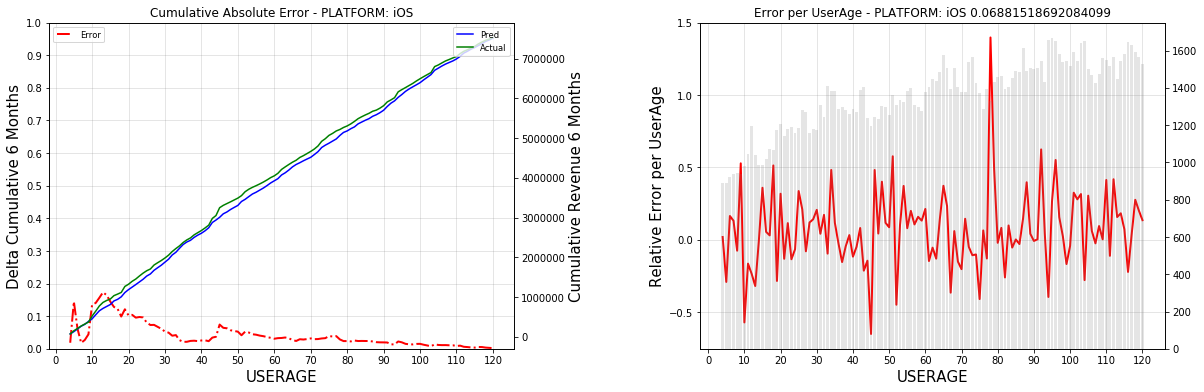

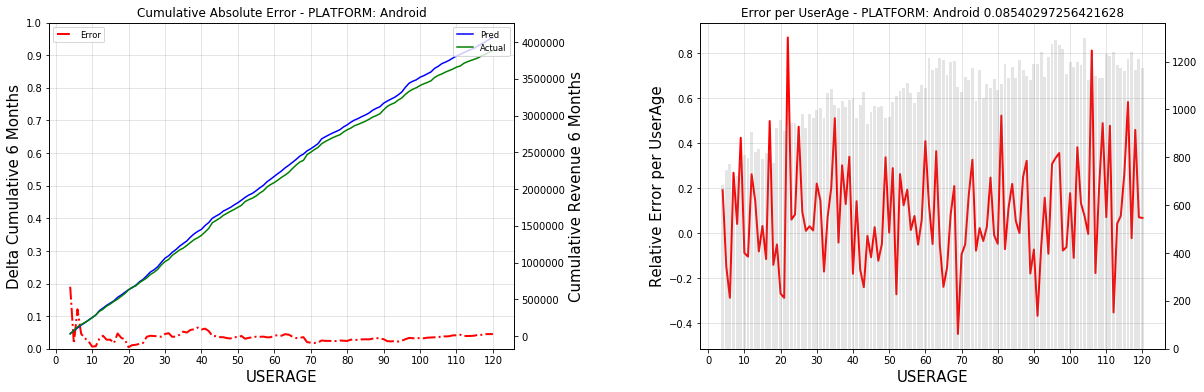

In [48]:
y_test['PLATFORM'] = np.where(y_test.GPS_PLATFORM>=y_test.IOS_PLATFORM,'Android','iOS')
for i in y_test.PLATFORM.unique():
    #print(i)
    perf_group_temp = y_test[y_test.PLATFORM==i]
    perf_group = perf_group_temp[['USERAGE','Prediction',FutureRevenue]].groupby(['USERAGE']).sum()
    count = perf_group_temp[['USERAGE','PSPLAYERID']].groupby(['USERAGE']).count()
    perf_group['COUNT'] = count
    fig = plt.figure(figsize=(20,6))
    gs = gridspec.GridSpec(nrows=1, 
                           ncols=2, 
                           figure=fig, 
                           width_ratios= [1, 1],
                           height_ratios=[1],
                           wspace=0.4,
                           hspace=0.2)
    ax1 = fig.add_subplot(gs[0,0:1])
    ax2 = fig.add_subplot(gs[0,1:2])
    ax11 = ax1.twinx()
    ax1.plot((perf_group['Prediction'].cumsum()-perf_group[FutureRevenue].cumsum()).abs()/perf_group[FutureRevenue].cumsum(), 'red', ls='-.', lw=2)
    ax11.plot(perf_group['Prediction'].cumsum(), 'blue')
    ax11.plot(perf_group[FutureRevenue].cumsum(), 'green')
    ax11.set_xticks(np.arange(0,121,10))
    ax1.set_yticks(np.arange(0,1.1,.1))
    ax1.set_ylim(0,1)
    ax1.set_title('Cumulative Absolute Error - PLATFORM: '+str(i))
    ax1.legend(['Error'], loc ='upper left', fontsize = 'small')
    ax11.legend(['Pred','Actual'], loc ='upper right', fontsize = 'small')
    ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax11.set_ylabel('Cumulative Revenue '+str(MonthPrediction)+' Months', fontdict={'fontsize':15})
    ax1.set_ylabel('Delta Cumulative '+str(MonthPrediction)+' Months', fontdict={'fontsize':15})
    ax1.set_xlabel('USERAGE', fontdict={'fontsize':15})
    ax22 = ax2.twinx()
    ax2.plot((perf_group.Prediction-perf_group[FutureRevenue])/perf_group[FutureRevenue], 'red', ls='-', lw=2)
    ax22.bar(perf_group.index, perf_group.COUNT, color='gray', alpha = 0.2)
    ax2.set_ylabel('Relative Error per UserAge', size = 15)
    ax2.set_xlabel('USERAGE', fontdict={'fontsize':15})
    ax2.set_title('Error per UserAge - PLATFORM: '+str(i)+' '+str(((perf_group.Prediction-perf_group[FutureRevenue])/perf_group[FutureRevenue]).mean()))
    ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax2.set_xticks(np.arange(0,121,10))
    plt.show()